In [1]:
# Upgrade to latest version of Pyrfume
#!pip install --user -U git+https://github.com/pyrfume/pyrfume
    
# And be sure to have pyrfume/data/cabinets/mainland.csv in place

In [2]:
from itertools import combinations
import numpy as np
import pandas as pd
from pyrfume.cabinets import get_mainland
from pyrfume.optimization import OdorantSetOptimizer, get_coverage, get_entropy, get_spacing
from rdkit import Chem
from rdkit.DataStructs import FingerprintSimilarity

In [3]:
# Get contents of Mainland cabinet (any dataframe could do)
cabinet = get_mainland()
# Get rid of any molecules without a valid SMILES stting
cabinet = cabinet.dropna(subset=['SMILES'])
# rdkit can't make mol from this one so drop that, too
cabinet = cabinet.drop(24766)
cids = list(cabinet.index)
cabinet.head()

,$/mol,AmountInStock,CAS,CatalogNumber,ChemicalName,D g/ml,Lot,MW,Price,Quantity,SMILES,SourcedFrom,SpecialHandling,Units,mol,notes,state
CID,,,,,,,,,,,,,,,,,
4,1.485721,Smelling,78-96-6,110248-100ML,Amino-2-propanol,0.973,NaN,75.10966,39.6,100.0,CC(CN)O,Sigma,NaN,mL,1.295439,NaN,liquid
119,2.058805,Smelling,56-12-2,A2129-10G,GABA,NaN,NaN,103.11976,11.1,10.0,C(CC(=O)O)CN,Sigma,NaN,g,0.096975,NaN,solid
127,2.782114,Smelling,156-38-7,H50004-5G,4-hydroxyphenylacetic acid,NaN,NaN,152.14732,19.9,5.0,C1=CC(=CC=C1CC(=O)O)O,Sigma,NaN,g,0.032863,NaN,solid
174,1.290035,Smelling,107-21-1,324558-100ML,Ethylene glycol,1.220,NaN,62.07000,38.4,100.0,C(CO)O,sigma,NaN,mL,1.965523,NaN,liquid
176,0.792392,Smelling,64-19-7,320099-500ML,acetic acid,1.049,NaN,60.05000,54.0,500.0,CC(=O)O,Sigma,NaN,mL,8.734388,primary odors-DD,Liquid


In [4]:
# Compute all fingerprints
fps = cabinet['SMILES'].apply(Chem.MolFromSmiles).apply(Chem.RDKFingerprint)
# And then Tanimot distances
tanimoto = pd.DataFrame(index=cids, columns=cids)
tanimoto[:] = [[FingerprintSimilarity(fp1, fp2) for fp1 in fps] for fp2 in fps]
tanimoto.head()

,4,119,127,174,176,177,179,180,190,196,...,23662757,23664008,23664011,23666342,23676745,23687511,23702150,24856164,54670067,92043494
4,1.000000,0.280000,0.033708,0.272727,0.214286,0.083333,0.232558,0.153846,0.006250,0.126984,...,0.051447,0.047619,0.060606,0.065868,0.080460,0.045455,0.046243,0.057692,0.028226,0.042500
119,0.280000,1.000000,0.077720,0.130435,0.318182,0.136364,0.305085,0.173913,0.014663,0.484375,...,0.103774,0.096210,0.118812,0.181287,0.156863,0.091922,0.093484,0.113208,0.057426,0.080882
127,0.033708,0.077720,1.000000,0.036145,0.085366,0.036585,0.064865,0.035714,0.059091,0.069652,...,0.060811,0.059829,0.077465,0.069767,0.076923,0.057851,0.058577,0.074830,0.063415,0.066540
174,0.272727,0.130435,0.036145,1.000000,0.375000,0.166667,0.171429,0.125000,0.003236,0.113208,...,0.019417,0.021021,0.023649,0.050633,0.078947,0.020057,0.017442,0.022508,0.016327,0.015038
176,0.214286,0.318182,0.085366,0.375000,1.000000,0.428571,0.270270,0.333333,0.003175,0.274510,...,0.032154,0.029762,0.047458,0.088608,0.189189,0.028409,0.028902,0.045161,0.020243,0.024938


In [5]:
# This could be any function whose first argument is integer indices (not CIDs!) into a dataframe
# of info about odorants (one odorant per row)
def mean_dist(indices, sim):
    """Return the summed Tanimoto distance of all pairs"""
    pairs = combinations(indices, 2)
    return np.mean([sim.iloc[x[0], x[1]] for x in pairs])

In [6]:
# Prettier printing
np.set_printoptions(precision=2, suppress=True)
# Some weight you can make up, each tuple is one weight under consideration.  
# Tuple item 1 is a cabinet dataframe column or a custom name
# Tuple item 2 is an operation of a function name and args to that function
# Tuple item 3 is the actual weight (make positive to maximize, negative to minimize)
weights = [('$/mol', 'mean', -5),
           ('MW', 'sum', 3),
           ('Tanimoto', (mean_dist, tanimoto), 1)]
# How many items you want in your set, e.g. how many odorants should the result contain?
n_desired = 25
# Create the optimizer.
# n_gen is the number of generations of optimization
# rescale_weights standardize all weights to be # of s.d. better/worse than random sets of items
optimizer = OdorantSetOptimizer(cabinet, n_desired, weights, n_gen=50, standardize_weights=True)
# Run the optimizer
pop, stats, hof, logbook = optimizer.run()

gen	nevals	avg             	best                     
0  	100   	[0.15 0.17 0.09]	[11.17 -0.36  2.48  1.93]
1  	161   	[-0.62  1.    0.28]	[13.21 -0.67  3.54 -0.78]
2  	157   	[-0.64  1.79  0.58]	[13.95 -0.53  3.78 -0.07]
3  	168   	[-0.62  2.52  0.75]	[17.05 -1.4   2.81  1.62]
4  	171   	[-0.59  3.31  0.95]	[19.42 -0.64  4.44  2.93]
5  	161   	[-0.39  4.23  1.4 ]	[23.54 -0.71  5.78  2.64]
6  	148   	[-0.51  4.67  1.73]	[24.39 -0.76  5.83  3.07]
7  	166   	[-0.41  5.36  1.99]	[24.39 -0.76  5.83  3.07]
8  	165   	[-0.35  6.08  1.94]	[32.23 -0.47  8.46  4.47]
9  	159   	[-0.36  6.42  2.09]	[32.23 -0.47  8.46  4.47]
10 	157   	[-0.39  6.68  2.37]	[32.23 -0.47  8.46  4.47]
11 	167   	[-0.43  7.02  2.44]	[32.23 -0.47  8.46  4.47]
12 	157   	[-0.32  7.73  2.52]	[32.84 -0.67  8.24  4.81]
13 	158   	[-0.34  8.25  2.91]	[32.84 -0.67  8.24  4.81]
14 	163   	[-0.45  8.45  3.07]	[34.15 -0.3   9.13  5.29]
15 	156   	[-0.51  8.35  3.81]	[34.15 -0.3   9.13  5.29]
16 	163   	[-0.48  8.52  4.16]	[34.8 

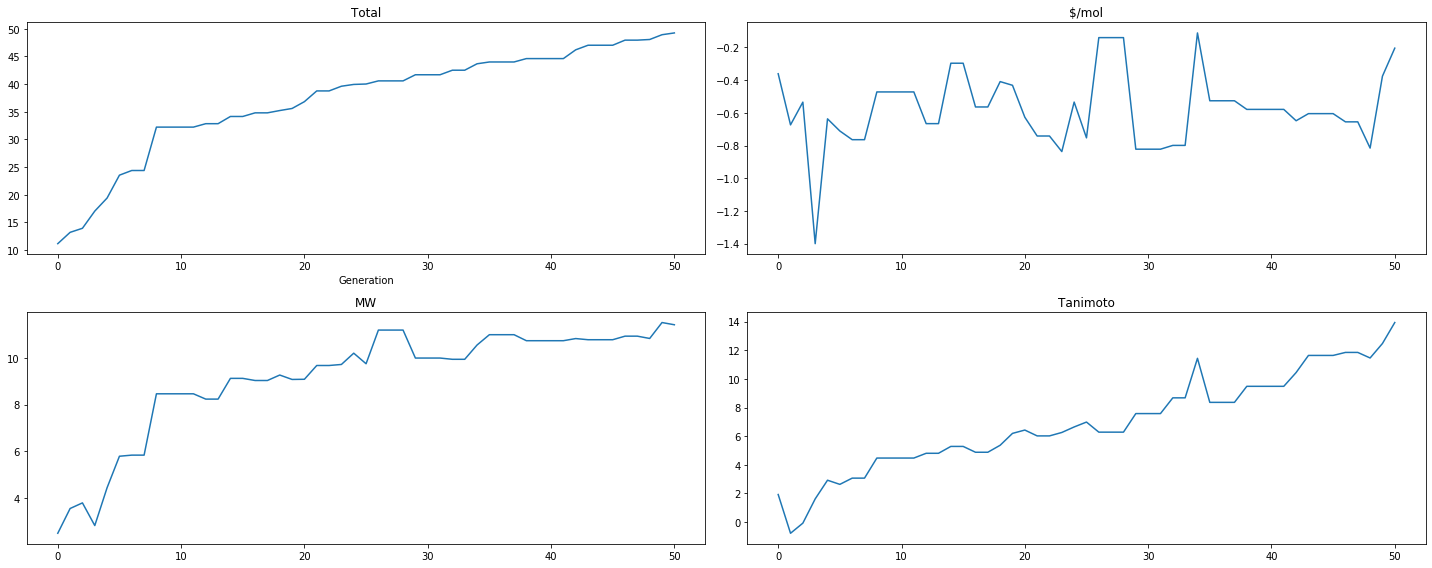

In [7]:
optimizer.plot_score_history()

In [8]:
# hof is the Hall of Fame, and contains the best 100 sets in descending order of fitness
# Get the very best one
best = hof[0]
# Show the first few items of this list, which is a subset of the original cabinet
cabinet.iloc[list(best)].head()

,$/mol,AmountInStock,CAS,CatalogNumber,ChemicalName,D g/ml,Lot,MW,Price,Quantity,SMILES,SourcedFrom,SpecialHandling,Units,mol,notes,state
CID,,,,,,,,,,,,,,,,,
235414,2.261025,Smelling,106-02-5,W284009-100G-K,exaltolide,0.918,NaN,240.38162,75.9,100.0,C1CCCCCCCOC(=O)CCCCCC1,Sigma,NaN,g,0.416005,NaN,solid
444041,3.890046,Smelling,7585-39-9,C4805-5G,β-Cyclodextrin,NaN,SLBV5469,1134.98420,34.2,5.0,C(C1C2C(C(C(O1)OC3C(OC(C(C3O)O)OC4C(OC(C(C4O)O...,Sigma,NaN,g,0.004405,NaN,Solid
14982,3.728281,Smelling,1405-86-3,50531-10G,Glycyrrhizic acid,NaN,bcbt0410,822.94200,65.0,10.0,O[C@@H]1[C@@H](O[C@H]2O[C@H](C(=O)O)[C@H]([C@H...,Sigma,NaN,g,0.012152,NaN,solid
379,2.078094,Smelling,124-07-2,C2875-100ML,Octanoic acid,0.910,NaN,144.24000,75.5,100.0,CCCCCCCC(=O)O,Sigma,NaN,mL,0.630893,NaN,Liquid
17525,1.082785,Smelling,2639-63-6,W256803-1KG-K,hexyl butyrate,0.851,NaN,172.26000,70.0,1.0,CCCCCCOC(=O)CCC,Sigma,NaN,kg,5.805178,NaN,Liquid
